<a href="https://colab.research.google.com/github/Erssa001/ECGR_4105/blob/main/HW5_P1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

import torch
import torch.optim as optim
torch.set_printoptions(edgeitems=2, linewidth=75)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics


In [16]:
t_c = torch.tensor([0.5, 14.0, 15.0, 28.0, 11.0, 8.0, 3.0, -4.0, 6.0, 13.0, 21.0])
t_u = torch.tensor([35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4])

t_un = t_u * 0.1

In [17]:
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

train_indices, val_indices  # <1>

(tensor([ 3,  2,  1,  9,  0,  6,  8, 10,  7]), tensor([4, 5]))

In [18]:
train_t_u = t_u[train_indices]
train_t_c = t_c[train_indices]

val_t_u = t_u[val_indices]
val_t_c = t_c[val_indices]

train_t_un = t_un[train_indices]
val_t_un = t_un[val_indices]

In [19]:
def model(t_u, w2, w1, b):
  return (w2 * t_u)**2 + (w1 * t_u) + b

def loss_fn(t_p, t_c):
  squared_diffs = (t_p - t_c)**2
  return squared_diffs.mean()

def training_loop(n_epochs, optimizer, params, train_t_u, val_t_u, train_t_c, val_t_c):
  for epoch in range(1, n_epochs + 1):
    train_t_p = model(train_t_u, *params)
    train_loss = loss_fn(train_t_p, train_t_c)

    with torch.no_grad(): # <1>
      val_t_p = model(val_t_u, *params)
      val_loss = loss_fn(val_t_p, val_t_c)
      assert val_loss.requires_grad == False # <2>

    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

    if ((epoch == 1) or (epoch % 500 == 0)):
      print(f"Epoch {epoch}, Training loss {train_loss.item():.4f}, Validation loss {val_loss.item():.4f}")

  return params

In [20]:
params = torch.tensor([0.0, 1.0, 0.0], requires_grad=True)
learning_rate = 0.01
optimizer = optim.SGD([params], lr=learning_rate)

SGD_linear = training_loop(
    n_epochs = 5000,
    optimizer = optimizer,
    params = params,
    train_t_u = train_t_un, # <1>
    val_t_u = val_t_un, # <1>
    train_t_c = train_t_c,
    val_t_c = val_t_c)
with torch.no_grad():
  SGD_linear[1] = SGD_linear[1] / 10

params = torch.tensor([1.0, 1.0, 0.0], requires_grad=True)
learning_rate = 0.0001
optimizer = optim.SGD([params], lr=learning_rate)

SGD_poly = training_loop(
    n_epochs = 5000,
    optimizer = optimizer,
    params = params,
    train_t_u = train_t_un, # <1>
    val_t_u = val_t_un, # <1>
    train_t_c = train_t_c,
    val_t_c = val_t_c)
with torch.no_grad():
  SGD_poly[0] = SGD_poly[0] / 10
  SGD_poly[1] = SGD_poly[1] / 10

params = torch.tensor([0.0, 1.0, 0.0], requires_grad=True)
learning_rate = 0.01
optimizer = optim.Adam([params], lr=learning_rate)

adam_linear = training_loop(
    n_epochs = 5000,
    optimizer = optimizer,
    params = params,
    train_t_u = train_t_u, # <1>
    val_t_u = val_t_u, # <1>
    train_t_c = train_t_c,
    val_t_c = val_t_c)

params = torch.tensor([1.0, 1.0, 0.0], requires_grad=True)
learning_rate = .01
optimizer = optim.Adam([params], lr=learning_rate)

adam_poly = training_loop(
    n_epochs = 5000,
    optimizer = optimizer,
    params = params,
    train_t_u = train_t_u, # <1>
    val_t_u = val_t_u, # <1>
    train_t_c = train_t_c,
    val_t_c = val_t_c)

Epoch 1, Training loss 93.9443, Validation loss 19.2545
Epoch 500, Training loss 7.1039, Validation loss 5.2108
Epoch 1000, Training loss 3.5098, Validation loss 3.8908
Epoch 1500, Training loss 3.0399, Validation loss 3.5031
Epoch 2000, Training loss 2.9784, Validation loss 3.3746
Epoch 2500, Training loss 2.9704, Validation loss 3.3296
Epoch 3000, Training loss 2.9693, Validation loss 3.3136
Epoch 3500, Training loss 2.9692, Validation loss 3.3078
Epoch 4000, Training loss 2.9692, Validation loss 3.3057
Epoch 4500, Training loss 2.9692, Validation loss 3.3050
Epoch 5000, Training loss 2.9692, Validation loss 3.3047
Epoch 1, Training loss 700.8782, Validation loss 562.9166
Epoch 500, Training loss 12.3260, Validation loss 5.0731
Epoch 1000, Training loss 9.8306, Validation loss 3.5221
Epoch 1500, Training loss 8.1045, Validation loss 2.4568
Epoch 2000, Training loss 6.9114, Validation loss 1.7278
Epoch 2500, Training loss 6.0868, Validation loss 1.2304
Epoch 3000, Training loss 5.5167

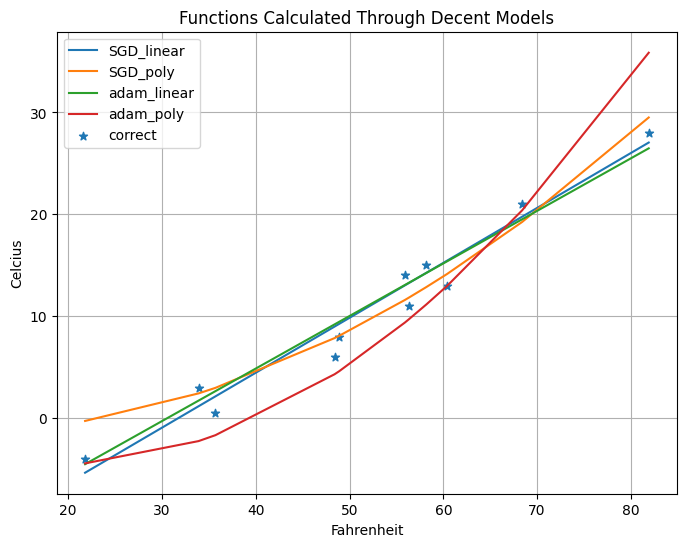

In [21]:
def predict(X, Y, params):
  for i, ele in enumerate(X):
    with torch.no_grad():
      prediction = model(ele.item(), *params)
    Y.append(prediction)

SGD_linear_pred = []
SGD_poly_pred = []
adam_linear_pred = []
adam_poly_pred = []

fahr_numpy = t_u.numpy()
sort_order = np.argsort(fahr_numpy)
fahr_numpy = fahr_numpy[sort_order]

predict(fahr_numpy, SGD_linear_pred, SGD_linear)
predict(fahr_numpy, SGD_poly_pred, SGD_poly)
predict(fahr_numpy, adam_linear_pred, adam_linear)
predict(fahr_numpy, adam_poly_pred, adam_poly)

plt.figure(figsize=(8, 6))

plt.plot(fahr_numpy, SGD_linear_pred, label='SGD_linear')
plt.plot(fahr_numpy, SGD_poly_pred, label='SGD_poly')
plt.plot(fahr_numpy, adam_linear_pred, label='adam_linear')
plt.plot(fahr_numpy, adam_poly_pred, label='adam_poly')
plt.scatter(t_u, t_c, label='correct', marker='*')

plt.title('Functions Calculated Through Decent Models')
plt.xlabel('Fahrenheit')
plt.ylabel('Celcius')
plt.legend()
plt.grid(True)
plt.show()
